# 1 - Imports

In [1]:
# Snowpark Imports
from snowflake.snowpark import Session
from snowflake.snowpark.context import get_active_session
import snowflake.snowpark.functions as F
from snowflake.snowpark.functions import col, lit
from snowflake.snowpark.types import FloatType
from snowflake.snowpark.exceptions import SnowparkSessionException

# Snowpark ML
from snowflake.ml.modeling.impute import SimpleImputer
from snowflake.ml.modeling.preprocessing import OrdinalEncoder, OneHotEncoder
from snowflake.ml.modeling.pipeline import Pipeline
from snowflake.ml.modeling.metrics.correlation import correlation
from snowflake.ml.modeling.xgboost import XGBRegressor
from snowflake.ml.modeling.model_selection import GridSearchCV
from snowflake.ml.modeling.metrics import mean_absolute_percentage_error
from snowflake.ml.registry import Registry

# Snowflake Task API
from snowflake.core import Root
from snowflake.core.database import Database
from snowflake.core.schema import Schema
from snowflake.core.warehouse import Warehouse
from snowflake.core import Root
from snowflake.core.task import StoredProcedureCall
from snowflake.core.task.dagv1 import DAG, DAGTask, DAGOperation
from snowflake.core._common import CreateMode

# Other Imports
from datetime import timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#
import warnings
warnings.filterwarnings("ignore")

# 2 - Create or Retrieve Session

In [2]:
try:
    # Get active session if running in Snowflake Notebook
    session = get_active_session()
except SnowparkSessionException:
    # Create a new session via .env file if running externally
    import os
    from dotenv import load_dotenv
    load_dotenv()
    snowflake_connection_cfg = {
        "ACCOUNT": os.getenv('SF_ACCOUNT'),
        "USER": os.getenv('SF_USER'),
        "ROLE": os.getenv('SF_ROLE'),
        "PASSWORD": os.getenv('SF_PASSWORD'),
    }

    # Creating Snowpark Session
    session = Session.builder.configs(snowflake_connection_cfg).create()

# 3 - Set Up Environment

In [3]:
# Create Database & Schema
root = Root(session)
ml_demo_db = Database(name="SIMPLE_ML_DB")
ml_demo_db = root.databases.create(ml_demo_db, mode='or_replace')
ml_demo_schema = Schema(name="SIMPLE_ML_SCHEMA")
ml_demo_schema = ml_demo_db.schemas.create(ml_demo_schema, mode='or_replace')

# Create warehouse
ml_wh = Warehouse(name="ML_WH", warehouse_size="XSMALL", auto_suspend=600, auto_resume='true')
warehouses = root.warehouses
ml_wh = warehouses.create(ml_wh)

# Set context
session.use_schema('SIMPLE_ML_DB.SIMPLE_ML_SCHEMA')
session.use_warehouse('ML_WH')

# 4 - Create Demo Data

In [4]:
num_rows = 1000
random_id = F.uniform(0,5, F.random()).as_('RAND_ID')
email = F.concat(F.call_builtin('RANDSTR', 10, F.random()), F.lit('@'), F.call_builtin('RANDSTR', 5, F.random()), F.lit('.com')).as_('EMAIL')
gender = F.when(F.uniform(1,10,F.random())<=7, F.lit('MALE')).otherwise('FEMALE').as_('GENDER')
yearly_spent = (F.round(F.uniform(100,75000,F.random()) / 100, 2)).as_('YEARLY_SPENT')
membership_status = F.when(col('YEARLY_SPENT') < 150, F.lit('BASIC'))\
    .when(col('YEARLY_SPENT') < 250, F.lit('BRONZE'))\
        .when(col('YEARLY_SPENT') < 350, F.lit('SILVER'))\
            .when(col('YEARLY_SPENT') < 550, F.lit('GOLD'))\
                .when(col('YEARLY_SPENT') < 650, F.lit('PLATIN'))\
                    .when(col('YEARLY_SPENT') >= 650, F.lit('DIAMOND')).as_('MEMBERSHIP_STATUS')
membership_length = (col('YEARLY_SPENT') / 100 + F.uniform(0,100, F.random())).cast(FloatType()).as_('MEMBERSHIP_LENGTH_DAYS')
avg_session_length = (col('YEARLY_SPENT') / 100 + F.uniform(0,5, F.random())).cast(FloatType()).as_('AVG_SESSION_LENGTH_MIN')
avg_time_on_app = (col('YEARLY_SPENT') / 100 + F.uniform(1,7, F.random())).cast(FloatType()).as_('AVG_TIME_ON_APP_MIN')
avg_time_on_website = (col('YEARLY_SPENT') / 100 + F.uniform(3,7, F.random())).cast(FloatType()).as_('AVG_TIME_ON_WEBSITE_MIN')

df = session.generator(random_id, email, yearly_spent, gender,membership_status, membership_length, avg_session_length, avg_time_on_app, avg_time_on_website, rowcount=num_rows)

# Add some missing data
df = df.with_column('MEMBERSHIP_STATUS', F.when(col('RAND_ID') == 0, None).otherwise(col('MEMBERSHIP_STATUS')))
df = df.with_column('MEMBERSHIP_LENGTH_DAYS', F.when(col('RAND_ID') == 1, None).otherwise(col('MEMBERSHIP_LENGTH_DAYS')))
df = df.with_column('AVG_SESSION_LENGTH_MIN', F.when(col('RAND_ID') == 2, None).otherwise(col('AVG_SESSION_LENGTH_MIN')))
df = df.with_column('AVG_TIME_ON_APP_MIN', F.when(col('RAND_ID') == 3, None).otherwise(col('AVG_TIME_ON_APP_MIN')))
df = df.with_column('AVG_TIME_ON_WEBSITE_MIN', F.when(col('RAND_ID') == 4, None).otherwise(col('AVG_TIME_ON_WEBSITE_MIN')))
df = df.drop('RAND_ID')

df.write.save_as_table('ECOMMERCE_DATA', mode='overwrite')

# 5 - Feature Engineering

In [5]:
# Create a Snowpark DataFrame
df = session.table('ECOMMERCE_DATA')
df.show()

# Describe data
df.describe().show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"EMAIL"               |"YEARLY_SPENT"  |"GENDER"  |"MEMBERSHIP_STATUS"  |"MEMBERSHIP_LENGTH_DAYS"  |"AVG_SESSION_LENGTH_MIN"  |"AVG_TIME_ON_APP_MIN"  |"AVG_TIME_ON_WEBSITE_MIN"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|16ZjthOyt1@8F9sS.com  |431.25          |MALE      |GOLD                 |21.3125                   |6.3125                    |8.3125                 |NULL                       |
|NWHXaMCnE8@Rmreq.com  |657.30          |MALE      |DIAMOND              |32.573                    |9.573                     |10.573                 |NULL                       |
|EbqTFJ5cJr@0VOge.com  |583.46          |MALE      |PLATIN               |85.8346              

In [6]:
# Split the data into train and test sets
train_df, test_df = df.random_split(weights=[0.9, 0.1], seed=0)
train_df.count(), test_df.count()

# Define sklearn-like Imputers and Encoders
si_numeric =  SimpleImputer(
    input_cols=['MEMBERSHIP_LENGTH_DAYS','AVG_SESSION_LENGTH_MIN','AVG_TIME_ON_APP_MIN','AVG_TIME_ON_WEBSITE_MIN'], 
    output_cols=['MEMBERSHIP_LENGTH_DAYS_IMP','AVG_SESSION_LENGTH_MIN_IMP','AVG_TIME_ON_APP_MIN_IMP','AVG_TIME_ON_WEBSITE_MIN_IMP'],
    strategy='mean',
    drop_input_cols=True
)

si_cat =  SimpleImputer(
    input_cols=['MEMBERSHIP_STATUS'], 
    output_cols=['MEMBERSHIP_STATUS_IMP'],
    strategy='most_frequent',
    drop_input_cols=True
)

# Define sklearn-like Encoders
categories = {
    "MEMBERSHIP_STATUS_IMP": np.array(["BASIC", "BRONZE", "SILVER", "GOLD", "PLATIN", "DIAMOND"]),
}
oe_categorical = OrdinalEncoder(
    input_cols=["MEMBERSHIP_STATUS_IMP"], 
    output_cols=["MEMBERSHIP_STATUS_IMP_OE"], 
    categories=categories,
    drop_input_cols=True
)

ohe_categorical = OneHotEncoder(
    input_cols=["GENDER"], 
    output_cols=["GENDER_OHE"],
    drop_input_cols=True
)

# Build the pipeline
preprocessing_pipeline = Pipeline(
    steps=[
        ('SI_CAT',si_cat),
        ("SI_NUMERIC",si_numeric),
        ("OE_CATEGORICAL",oe_categorical),
        ("OHE_CATEGORICAL",ohe_categorical),
    ]
)

# Fit the pipeline and transform data
transformed_train_df = preprocessing_pipeline.fit(train_df).transform(train_df).cache_result()
transformed_train_df.show()

transformed_test_df = preprocessing_pipeline.transform(test_df).cache_result()
transformed_test_df.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"GENDER_OHE_FEMALE"  |"GENDER_OHE_MALE"  |"MEMBERSHIP_STATUS_IMP_OE"  |"MEMBERSHIP_LENGTH_DAYS_IMP"  |"AVG_SESSION_LENGTH_MIN_IMP"  |"AVG_TIME_ON_APP_MIN_IMP"  |"AVG_TIME_ON_WEBSITE_MIN_IMP"  |"EMAIL"               |"YEARLY_SPENT"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|0                    |1                  |3.0                         |21.3125                       |6.3125                        |8.3125                     |8.663380025773195              |16ZjthOyt1@8F9sS.com  |431.25          |
|0                    |1                  |5.0              

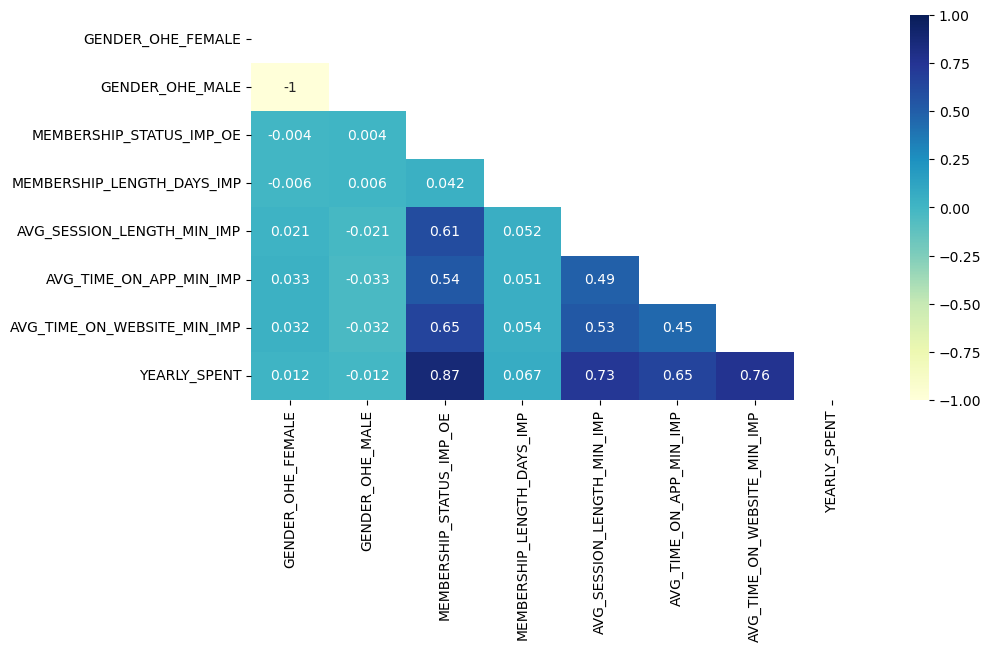

In [7]:
# Calculate correlations
corr_train_df = correlation(df=transformed_train_df)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_train_df, dtype=bool))

# Create a heatmap with the features
plt.figure(figsize=(10, 5))
heatmap = sns.heatmap(corr_train_df.round(3), mask=mask, cmap="YlGnBu", annot=True, vmin=-1, vmax=1)

In [8]:
session.sql("ALTER WAREHOUSE ML_WH SET WAREHOUSE_SIZE='MEDIUM'").collect()

[Row(status='Statement executed successfully.')]

# 6 - Model Training

In [9]:
feature_cols = [
    'GENDER_OHE_FEMALE',
    'GENDER_OHE_MALE',
    'MEMBERSHIP_STATUS_IMP_OE',
    'MEMBERSHIP_LENGTH_DAYS_IMP',
    'AVG_SESSION_LENGTH_MIN_IMP',
    'AVG_TIME_ON_APP_MIN_IMP',
    'AVG_TIME_ON_WEBSITE_MIN_IMP'
]
label_cols = ['YEARLY_SPENT']
output_cols = ['YEARLY_SPENT_PREDICTION']


grid_search = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid={
        "n_estimators":[100, 200, 300, 400],
        "learning_rate":[0.1, 0.2, 0.3],
    },
    n_jobs = -1,
    scoring="neg_mean_absolute_percentage_error",
    input_cols=feature_cols,
    label_cols=label_cols,
    output_cols=output_cols
)

# Train
grid_search.fit(transformed_train_df)

Package 'fastparquet' is not installed in the local environment. Your UDF might not work when the package is installed on the server but not on your local environment.


In [10]:
session.sql("ALTER WAREHOUSE ML_WH SET WAREHOUSE_SIZE='XSMALL'").collect()

[Row(status='Statement executed successfully.')]

# 7 - Model Evaluation

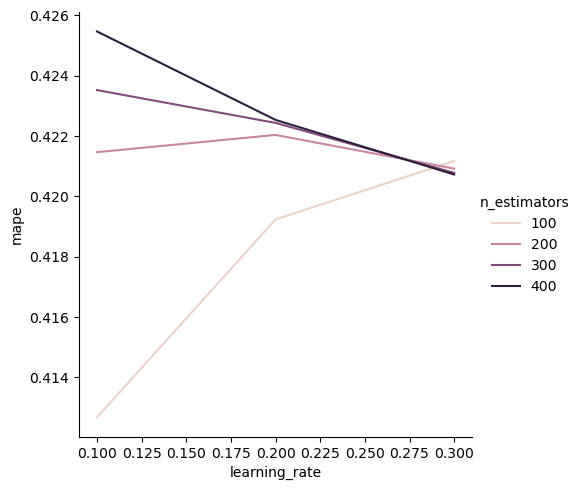

In [11]:
# Analyze grid search results
gs_results = grid_search.to_sklearn().cv_results_
n_estimators_val = []
learning_rate_val = []
for param_dict in gs_results["params"]:
    n_estimators_val.append(param_dict["n_estimators"])
    learning_rate_val.append(param_dict["learning_rate"])
mape_val = gs_results["mean_test_score"]*-1

gs_results_df = pd.DataFrame(data={
    "n_estimators":n_estimators_val,
    "learning_rate":learning_rate_val,
    "mape":mape_val})

sns.relplot(data=gs_results_df, x="learning_rate", y="mape", hue="n_estimators", kind="line")

plt.show()

----------------------------------------------
|"YEARLY_SPENT"  |"YEARLY_SPENT_PREDICTION"  |
----------------------------------------------
|507.97          |453                        |
|571.9           |578                        |
|449.0           |405                        |
|575.56          |591                        |
|635.08          |603                        |
|57.87           |74                         |
|516.15          |492                        |
|530.33          |484                        |
|599.75          |585                        |
|171.57          |422                        |
----------------------------------------------

Mean absolute percentage error: 0.2666753600450465


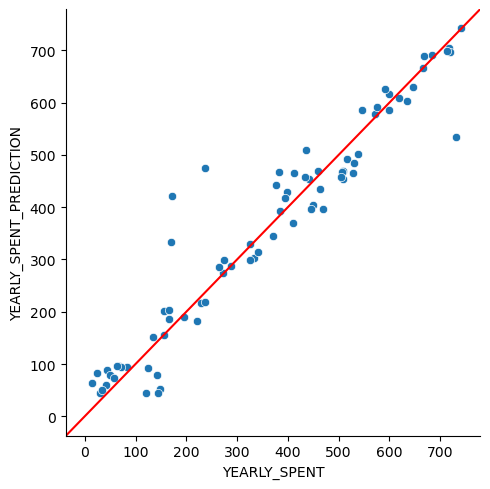

In [12]:
# Predict
result = grid_search.predict(transformed_test_df)

# Analyze results
mape = mean_absolute_percentage_error(df=result, 
                                        y_true_col_names="YEARLY_SPENT", 
                                        y_pred_col_names="YEARLY_SPENT_PREDICTION")

result.select("YEARLY_SPENT", "YEARLY_SPENT_PREDICTION").show()
print(f"Mean absolute percentage error: {mape}")

# Plot actual vs predicted 
g = sns.relplot(
    data=result["YEARLY_SPENT", "YEARLY_SPENT_PREDICTION"].to_pandas().astype("float64"), 
    x="YEARLY_SPENT", 
    y="YEARLY_SPENT_PREDICTION", 
    kind="scatter")
g.ax.axline((0,0), slope=1, color="r")

plt.show()

# 8 - Register & Run Model

In [13]:
# Create reference to model registry
reg = Registry(session=session, database_name=session.get_current_database(), schema_name=session.get_current_schema())

# Get latest model version
try:
    model_versions = reg.get_model("ECOMMERCE_SPENT_MODEL").show_versions()
    idx = model_versions['created_on'].idxmax()
    most_recent_version = model_versions.loc[idx]
    new_version = 'V'+str(int(most_recent_version['name'][1:])+1)
except:
    new_version = 'V0'

# Register new model version
registered_model = reg.log_model(
    grid_search,
    model_name="ECOMMERCE_SPENT_MODEL",
    version_name=new_version,
    comment="Model trained using GridsearchCV in Snowpark to predict customer's yearly spending.",
    metrics={"mean_abs_pct_err": mape},
    conda_dependencies=['xgboost'],
    sample_input_data=transformed_train_df.select(feature_cols).limit(100)
)

# Create predictions from registered model
predictions_df = registered_model.run(transformed_test_df, function_name="predict")
predictions_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"EMAIL"               |"YEARLY_SPENT"  |"GENDER_OHE_FEMALE"  |"GENDER_OHE_MALE"  |"MEMBERSHIP_STATUS_IMP_OE"  |"MEMBERSHIP_LENGTH_DAYS_IMP"  |"AVG_SESSION_LENGTH_MIN_IMP"  |"AVG_TIME_ON_APP_MIN_IMP"  |"AVG_TIME_ON_WEBSITE_MIN_IMP"  |"YEARLY_SPENT_PREDICTION"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|0wc0g9sp0E@phfFY.com  |507.97          |1                    |0                  |3.0                         |53.887544921875               |9.0797                        |9.0797                     |9.0797   

In [14]:
# Create a view that will be used in SQL to predict the target variable
transformed_test_df.create_or_replace_temp_view('INFERENCE_TEST')

[Row(status='View INFERENCE_TEST successfully created.')]

In [15]:
# SQL Execution of the trained model
session.sql("""
    SELECT *, 
        ECOMMERCE_SPENT_MODEL!PREDICT(
            GENDER_OHE_FEMALE,
            GENDER_OHE_MALE,
            MEMBERSHIP_STATUS_IMP_OE,
            MEMBERSHIP_LENGTH_DAYS_IMP,
            AVG_SESSION_LENGTH_MIN_IMP,
            AVG_TIME_ON_APP_MIN_IMP,
            AVG_TIME_ON_WEBSITE_MIN_IMP)['YEARLY_SPENT_PREDICTION'] AS YEARLY_SPENT_PREDICTION
    FROM INFERENCE_TEST
""").show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"GENDER_OHE_FEMALE"  |"GENDER_OHE_MALE"  |"MEMBERSHIP_STATUS_IMP_OE"  |"MEMBERSHIP_LENGTH_DAYS_IMP"  |"AVG_SESSION_LENGTH_MIN_IMP"  |"AVG_TIME_ON_APP_MIN_IMP"  |"AVG_TIME_ON_WEBSITE_MIN_IMP"  |"EMAIL"               |"YEARLY_SPENT"  |"YEARLY_SPENT_PREDICTION"  |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|1                    |0                  |3.0                         |53.887544921875               |9.0797                        |9.0797                     |9.0797                         |0wc0g9sp0E@phfFY.

# 9 - Automate Pipeline

In [16]:
# Create a new stage for the pipeline
session.sql("CREATE OR REPLACE STAGE DAG_STAGE").show()

----------------------------------------------
|"status"                                    |
----------------------------------------------
|Stage area DAG_STAGE successfully created.  |
----------------------------------------------



In [17]:
# Define preprocessing task
def preprocess_data(session: Session) -> str:
    df = session.table('ECOMMERCE_DATA')
    # Split the data into train and test sets
    train_df, test_df = df.random_split(weights=[0.9, 0.1])
    # Transform datasets and persist them
    transformed_train_df = preprocessing_pipeline.transform(train_df)
    transformed_train_df.write.save_as_table('ECOMMERCE_DATA_TRAIN_PREPARED', mode='overwrite')
    num_rows_train = session.table('ECOMMERCE_DATA_TRAIN_PREPARED').count()
    transformed_test_df = preprocessing_pipeline.transform(test_df)
    transformed_test_df.write.save_as_table('ECOMMERCE_DATA_TEST_PREPARED', mode='overwrite')
    num_rows_test = session.table('ECOMMERCE_DATA_TEST_PREPARED').count()
    return f"Prepared new training table with {num_rows_train} customers and new test table with {num_rows_test} customers."

# Define model training task
def train_model(session: Session) -> str:
    reg = Registry(session=session, database_name="SIMPLE_ML_DB", schema_name="SIMPLE_ML_SCHEMA")
    df = session.table('ECOMMERCE_DATA_TRAIN_PREPARED')
    df_test = session.table('ECOMMERCE_DATA_TEST_PREPARED')
    feature_cols = [
        'GENDER_OHE_FEMALE',
        'GENDER_OHE_MALE',
        'MEMBERSHIP_STATUS_IMP_OE',
        'MEMBERSHIP_LENGTH_DAYS_IMP',
        'AVG_SESSION_LENGTH_MIN_IMP',
        'AVG_TIME_ON_APP_MIN_IMP',
        'AVG_TIME_ON_WEBSITE_MIN_IMP'
    ]
    label_cols = ['YEARLY_SPENT']
    output_cols = ['YEARLY_SPENT_PREDICTION']

    # Define parameter tuning
    grid_search = GridSearchCV(
        estimator=XGBRegressor(),
        param_grid={
            "n_estimators":[100, 200, 300, 400],
            "learning_rate":[0.1, 0.2, 0.3],
        },
        n_jobs = -1,
        scoring="neg_mean_absolute_percentage_error",
        input_cols=feature_cols,
        label_cols=label_cols,
        output_cols=output_cols
    )
    
    # Train
    grid_search.fit(df)

    # Evaluate
    result = grid_search.predict(df_test)
    mape = mean_absolute_percentage_error(df=result, y_true_col_names="YEARLY_SPENT", y_pred_col_names="YEARLY_SPENT_PREDICTION")

    # Get latest model version
    model_versions = reg.get_model("ECOMMERCE_SPENT_MODEL").show_versions()
    idx = model_versions['created_on'].idxmax()
    most_recent_version = model_versions.loc[idx]
    new_version = 'V'+str(int(most_recent_version['name'][1:])+1)

    # Register new model version
    registered_model = reg.log_model(
        grid_search,
        model_name="ECOMMERCE_SPENT_MODEL",
        version_name=new_version,
        metrics={"mean_abs_pct_err": mape},
        comment="Model trained using GridsearchCV in Snowpark to predict customer's yearly spending.",
        sample_input_data=df.select(feature_cols).limit(100)
    )
    
    return f"Registered new model with version: {new_version}"

In [18]:
root = Root(session)

with DAG("MY_TRAINING_PIPELINE", stage_location='DAG_STAGE', schedule=timedelta(minutes=2)) as dag:
    task_preprocess_data = DAGTask(
        "PREPROCESS_DATA",
        definition=StoredProcedureCall(preprocess_data, stage_location='DAG_STAGE', packages=["snowflake-snowpark-python","snowflake-ml-python"]),
        warehouse="ML_WH"
    )
    task_train_model = DAGTask(
        "TRAIN_MODEL",
        definition=StoredProcedureCall(train_model, stage_location='DAG_STAGE', packages=["snowflake-snowpark-python","snowflake-ml-python", "xgboost"]),
        warehouse="ML_WH"
    )

task_preprocess_data >> task_train_model
dag_op = DAGOperation(ml_demo_schema)
dag_op.deploy(dag, mode=CreateMode.or_replace)
dag_op.run(dag)

### Display the model versions
Every couple of minutes, you should see a new version popping up.

In [19]:
reg.show_models()

,created_on,name,database_name,schema_name,comment,owner,default_version_name,versions
0,2024-05-05 23:44:51.416000-07:00,ECOMMERCE_SPENT_MODEL,SIMPLE_ML_DB,SIMPLE_ML_SCHEMA,None,ACCOUNTADMIN,V0,"[""V0""]"


# 10 - Clean Up

In [ ]:
#ml_wh.delete()
#ml_demo_db.delete()
#session.close()